# Examples with performance using Mandelbrot calculation

[Data Parallel Extensions for Python](https://intelpython.github.io/DPEP/main/) makes calculations on the gpu faster than on the cpu. 
Let's look at performance using the example of the Mandelbrot set computation. 
The Mandelbrot set is the set of points `c` on the complex plane for which the recurrence relation $ z_{n+1} = z_n^2+c $ at 
$ z_0=0 $ defines a bounded sequence. In other words, it is the set of such `c` for which there exists a real `R` such that the inequality 
$ |z_n|<R $
holds for all natural `n`. 
The definition and the name belong to the French mathematician Adrien Duadi, after the mathematician Benoit Mandelbrot.

**Prerequisits:** please be sure that Matplotlib library is installed

### The Mandelbrot set based on the NumPy* library

Let's build the Mandelbrot set based on the NumPy* library and measure its performance. We will use these values for a baseline.

497 ms ± 35.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


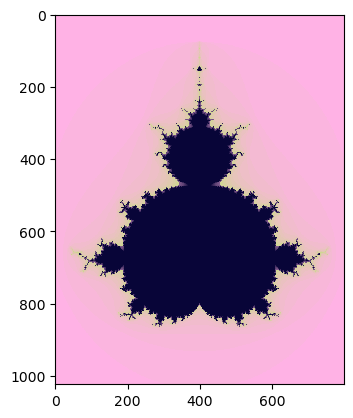

In [1]:
#calculating the Mandelbrot set on CPU using NumPy* library

#set variables
DISPLAY_W, DISPLAY_H = 1024, 800
OFFSET_X = 1.4 * DISPLAY_W // 2
OFFSET_Y = DISPLAY_H // 2
ZOOM = 2.5 / DISPLAY_H
MAX_ITER = 30

#import NumPy* library
import numpy as np
#import Matplotlib* library to make visualisation
import matplotlib.pyplot as plt
%matplotlib inline 

#create arrays
c1 = np.asarray([0.0, 0.0, 0.2])
c2 = np.asarray([1.0, 0.7, 0.9])
c3 = np.asarray([0.6, 1.0, 0.2])

#perform calculations
def color_by_intensity(intensity):
    intensity = np.broadcast_to(intensity[:, :, np.newaxis], intensity.shape + (3,))
    return np.where(
        intensity < 0.5,
        c3 * intensity + c2 * (1.0 - intensity),
        c1 * intensity + c2 * (1.0 - intensity),
    )

#implementation of mandelbrot set calculation
def mandelbrot(w, h, zoom, offset, values):
    x = np.linspace(0, w, num=w, dtype=np.float32)
    y = np.linspace(0, h, num=h, dtype=np.float32)
    xx = (x - offset[0]) * zoom
    yy = (y - offset[1]) * zoom
    c = xx + 1j * yy[:, np.newaxis]

    n_iter = np.full(c.shape, 0)  # 2d array
    z = np.zeros(c.shape, np.csingle)  # 2d array too
    mask = n_iter < MAX_ITER  # Initialize with True
    for i in range(MAX_ITER):
        z[mask] = z[mask] ** 2 + c[mask]
        mask = mask & (np.abs(z) <= 2.0)
        n_iter[mask] = i

    intensity = n_iter.T / MAX_ITER
    #values = (color_by_intensity(intensity) * 255).astype(np.uint8)
    values = (color_by_intensity(intensity) * 255).astype(np.int32)
    return values

def init_values(w, h):
    return np.full((w, h, 3), 0, dtype=np.int32)
    #return np.full((w, h, 3), 0, dtype=np.uint8)

def asnumpy(values):
    return values

class Fractal:
    def __init__(self, w, h, zoom, offset):
        self.w = w
        self.h = h
        self.values = init_values(w, h)
        self.zoom = zoom
        self.offset = offset

    def calculate(self):
        self.values = mandelbrot(self.w, self.h, self.zoom, self.offset, self.values)

    def draw(self):
        plt.imshow(self.values)
            
def main():
    fractal = Fractal(DISPLAY_W, DISPLAY_H, ZOOM, (OFFSET_X, OFFSET_Y))
    #calculating the Mandelbrot set and measuring performance
    %timeit fractal.calculate()
    #draw results
    fractal.draw()

if __name__ == "__main__":
    main()

Now we have the results of code execution on the CPU using the NumPy* library

### The Mandelbrot set based on the Data Parallel Extension for NumPy

To run Python on the GPU, we have to make minor changes to our CPU script, namely:
1. Changing import statement(s) (call the Data Parallel Extension for NumPy)
2. Specifying on which device(s) the data is allocated
3. Explicitly copying data between devices and the host as needed

level_zero:gpu
947 ms ± 19.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


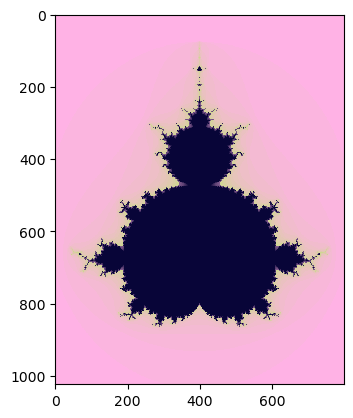

In [3]:
#calculating the Mandelbrot set on GPU using dpnp library

#set variables
DISPLAY_W, DISPLAY_H = 1024, 800
OFFSET_X = 1.4 * DISPLAY_W // 2
OFFSET_Y = DISPLAY_H // 2
ZOOM = 2.5 / DISPLAY_H
MAX_ITER = 30

#specify the device type
import os
os.environ["SYCL_DEVICE_FILTER"] = "level_zero:gpu"
#os.environ["SYCL_DEVICE_FILTER"] = "opencl:gpu"
#os.environ["SYCL_DEVICE_FILTER"] = "cpu"
print (os.environ["SYCL_DEVICE_FILTER"])

#import dpnp library
import dpnp as np

#import Matplotlib* library to make visualisation
import matplotlib.pyplot as plt
%matplotlib inline 

#create arrays
c1 = np.asarray([0.0, 0.0, 0.2])
c2 = np.asarray([1.0, 0.7, 0.9])
c3 = np.asarray([0.6, 1.0, 0.2])

#perform calculations
def color_by_intensity(intensity):
    intensity = np.broadcast_to(intensity[:, :, np.newaxis], intensity.shape + (3,))
    return np.where(
        intensity < 0.5,
        c3 * intensity + c2 * (1.0 - intensity),
        c1 * intensity + c2 * (1.0 - intensity),
    )

#implementation of mandelbrot set calculation
def mandelbrot(w, h, zoom, offset, values):
    x = np.linspace(0, w, num=w, dtype=np.float32)
    y = np.linspace(0, h, num=h, dtype=np.float32)
    xx = (x - offset[0]) * zoom
    yy = (y - offset[1]) * zoom
    c = xx + 1j * yy[:, np.newaxis]

    
    n_iter = np.full(c.shape, 0)  # 2d array
    z = np.zeros(c.shape, dtype=np.csingle)  # 2d array too

    mask = n_iter < MAX_ITER  # Initialize with True
    for i in range(MAX_ITER):
        z[mask] = z[mask] ** 2 + c[mask]
        mask = mask & (np.abs(z) <= 2.0)
        n_iter[mask] = i

    intensity = n_iter.T / MAX_ITER
    values = (color_by_intensity(intensity) * 255).astype(np.int32)
    return values

def init_values(w, h):
    return np.full((w, h, 3), 0, dtype=np.int32)

def asnumpy(values):
    return values

class Fractal:
    def __init__(self, w, h, zoom, offset):
        self.w = w
        self.h = h
        self.values = init_values(w, h)
        self.zoom = zoom
        self.offset = offset

    def calculate(self):
        self.values = mandelbrot(self.w, self.h, self.zoom, self.offset, self.values)

    def draw(self):
        #return the NumPy* array with input data
        cpu_values = np.asnumpy(self.values)
        plt.imshow(cpu_values)
            
def main():
    fractal = Fractal(DISPLAY_W, DISPLAY_H, ZOOM, (OFFSET_X, OFFSET_Y))
    #calculating the Mandelbrot set and measuring performance
    %timeit fractal.calculate()
    #draw results
    fractal.draw()

if __name__ == "__main__":
    main()

You can compare the performance of the gpu calculations with the dpnp library using the OpenCL (Open Computing Language) driver. For both type of GPU drivers performance will be 2 times faster than on cpu.

opencl:gpu
967 ms ± 15.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


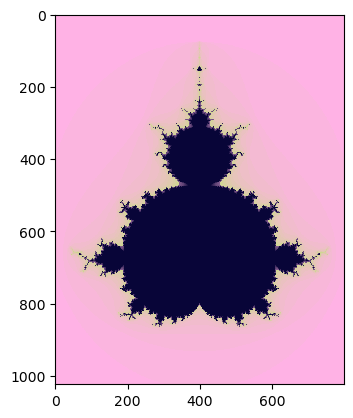

In [2]:
#calculating the Mandelbrot set on OpenCL GPU device using dpnp library

#set variables
DISPLAY_W, DISPLAY_H = 1024, 800
OFFSET_X = 1.4 * DISPLAY_W // 2
OFFSET_Y = DISPLAY_H // 2
ZOOM = 2.5 / DISPLAY_H
MAX_ITER = 30

#specify the device type
import os
#os.environ["SYCL_DEVICE_FILTER"] = "level_zero:gpu"
os.environ["SYCL_DEVICE_FILTER"] = "opencl:gpu"
#os.environ["SYCL_DEVICE_FILTER"] = "cpu"
print (os.environ["SYCL_DEVICE_FILTER"])

#import dpnp library
import dpnp as np

#import Matplotlib* library to make visualisation
import matplotlib.pyplot as plt
%matplotlib inline 

#create arrays
c1 = np.asarray([0.0, 0.0, 0.2])
c2 = np.asarray([1.0, 0.7, 0.9])
c3 = np.asarray([0.6, 1.0, 0.2])

#perform calculations
def color_by_intensity(intensity):
    intensity = np.broadcast_to(intensity[:, :, np.newaxis], intensity.shape + (3,))
    return np.where(
        intensity < 0.5,
        c3 * intensity + c2 * (1.0 - intensity),
        c1 * intensity + c2 * (1.0 - intensity),
    )

#implementation of mandelbrot set calculation
def mandelbrot(w, h, zoom, offset, values):
    x = np.linspace(0, w, num=w, dtype=np.float32)
    y = np.linspace(0, h, num=h, dtype=np.float32)
    xx = (x - offset[0]) * zoom
    yy = (y - offset[1]) * zoom
    c = xx + 1j * yy[:, np.newaxis]

    
    n_iter = np.full(c.shape, 0)  # 2d array
    z = np.zeros(c.shape, dtype=np.csingle)  # 2d array too

    mask = n_iter < MAX_ITER  # Initialize with True
    for i in range(MAX_ITER):
        z[mask] = z[mask] ** 2 + c[mask]
        mask = mask & (np.abs(z) <= 2.0)
        n_iter[mask] = i

    intensity = n_iter.T / MAX_ITER
    values = (color_by_intensity(intensity) * 255).astype(np.int32)
    return values

def init_values(w, h):
    return np.full((w, h, 3), 0, dtype=np.int32)

def asnumpy(values):
    return values

class Fractal:
    def __init__(self, w, h, zoom, offset):
        self.w = w
        self.h = h
        self.values = init_values(w, h)
        self.zoom = zoom
        self.offset = offset

    def calculate(self):
        self.values = mandelbrot(self.w, self.h, self.zoom, self.offset, self.values)

    def draw(self):
        #return the NumPy* array with input data
        cpu_values = np.asnumpy(self.values)
        plt.imshow(cpu_values)
            
def main():
    fractal = Fractal(DISPLAY_W, DISPLAY_H, ZOOM, (OFFSET_X, OFFSET_Y))
    #calculating the Mandelbrot set and measuring performance
    %timeit fractal.calculate()
    #draw results
    fractal.draw()

if __name__ == "__main__":
    main()

Calculations using the Data Parallel Extension for NumPy on the GPU will be faster than the same calculations using the same library on the CPU. Lets compare this.

cpu
908 ms ± 9.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


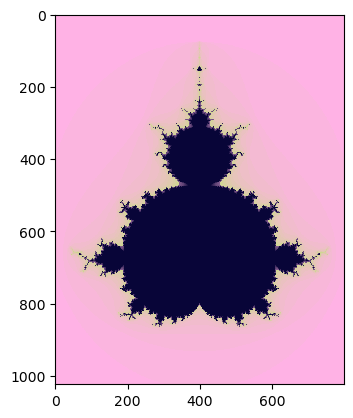

In [1]:
#calculating the Mandelbrot set on CPU device using dpnp library

#set variables
DISPLAY_W, DISPLAY_H = 1024, 800
OFFSET_X = 1.4 * DISPLAY_W // 2
OFFSET_Y = DISPLAY_H // 2
ZOOM = 2.5 / DISPLAY_H
MAX_ITER = 30

#specify the device type
import os
#os.environ["SYCL_DEVICE_FILTER"] = "level_zero:gpu"
#os.environ["SYCL_DEVICE_FILTER"] = "opencl:gpu"
os.environ["SYCL_DEVICE_FILTER"] = "cpu"
print (os.environ["SYCL_DEVICE_FILTER"])

#import dpnp library
import dpnp as np

#import Matplotlib* library to make visualisation
import matplotlib.pyplot as plt
%matplotlib inline 

#create arrays
c1 = np.asarray([0.0, 0.0, 0.2])
c2 = np.asarray([1.0, 0.7, 0.9])
c3 = np.asarray([0.6, 1.0, 0.2])

#perform calculations
def color_by_intensity(intensity):
    intensity = np.broadcast_to(intensity[:, :, np.newaxis], intensity.shape + (3,))
    return np.where(
        intensity < 0.5,
        c3 * intensity + c2 * (1.0 - intensity),
        c1 * intensity + c2 * (1.0 - intensity),
    )

#implementation of mandelbrot set calculation
def mandelbrot(w, h, zoom, offset, values):
    x = np.linspace(0, w, num=w, dtype=np.float32)
    y = np.linspace(0, h, num=h, dtype=np.float32)
    xx = (x - offset[0]) * zoom
    yy = (y - offset[1]) * zoom
    c = xx + 1j * yy[:, np.newaxis]

    
    n_iter = np.full(c.shape, 0)  # 2d array
    z = np.zeros(c.shape, dtype=np.csingle)  # 2d array too

    mask = n_iter < MAX_ITER  # Initialize with True
    for i in range(MAX_ITER):
        z[mask] = z[mask] ** 2 + c[mask]
        mask = mask & (np.abs(z) <= 2.0)
        n_iter[mask] = i

    intensity = n_iter.T / MAX_ITER
    values = (color_by_intensity(intensity) * 255).astype(np.int32)
    return values

def init_values(w, h):
    return np.full((w, h, 3), 0, dtype=np.int32)

def asnumpy(values):
    return values

class Fractal:
    def __init__(self, w, h, zoom, offset):
        self.w = w
        self.h = h
        self.values = init_values(w, h)
        self.zoom = zoom
        self.offset = offset

    def calculate(self):
        self.values = mandelbrot(self.w, self.h, self.zoom, self.offset, self.values)

    def draw(self):
        #return the NumPy* array with input data
        cpu_values = np.asnumpy(self.values)
        plt.imshow(cpu_values)
            
def main():
    fractal = Fractal(DISPLAY_W, DISPLAY_H, ZOOM, (OFFSET_X, OFFSET_Y))
    #calculating the Mandelbrot set and measuring performance
    %timeit fractal.calculate()
    #draw results
    fractal.draw()

if __name__ == "__main__":
    main()

### The Mandelbrot set on the Numba

If we run the Mandelbrot set on Numba, the high-performance Python compiler, we see that the computation on it is faster than on the Numpy library.

7.23 ms ± 875 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


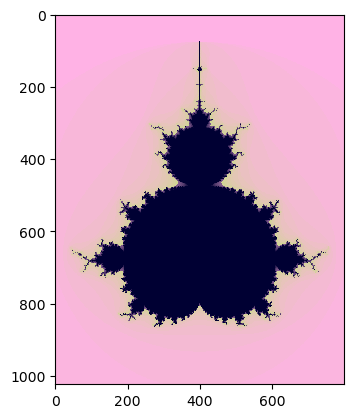

In [6]:
#calculating the Mandelbrot set on CPU device using dpnp library

#set variables
DISPLAY_W, DISPLAY_H = 1024, 800
OFFSET_X = 1.4 * DISPLAY_W // 2
OFFSET_Y = DISPLAY_H // 2
ZOOM = 2.5 / DISPLAY_H
MAX_ITER = 30

#import libraries
import numpy as np
import numba as nb

#import Matplotlib* library to make visualisation
import matplotlib.pyplot as plt
%matplotlib inline 

nb.config.THREADING_LAYER = "omp"

#perform calculations
@nb.jit(fastmath=True, nopython=True)
def color_by_intensity(intensity, c1, c2, c3):
    if intensity < 0.5:
        return c3 * intensity + c2 * (1.0 - intensity)
    else:
        return c1 * intensity + c2 * (1.0 - intensity)

@nb.jit(fastmath=True, nopython=True)
def mandel(x, y):
    c = complex(x, y)
    z = 0.0j
    for i in range(MAX_ITER):
        z = z * z + c
        if (z.real * z.real + z.imag * z.imag) > 4.0:
            return i
    return MAX_ITER

#implementation of mandelbrot set calculation
@nb.jit(fastmath=True, nopython=True, parallel=True)
def mandelbrot(w, h, zoom, offset, values):
    c1 = np.asarray([0.0, 0.0, 0.2])
    c2 = np.asarray([1.0, 0.7, 0.9])
    c3 = np.asarray([0.6, 1.0, 0.2])

    for x in nb.prange(w):
        for y in range(h):
            xx = (x - offset[0]) * zoom
            yy = (y - offset[1]) * zoom
            intensity = mandel(xx, yy) / MAX_ITER
            for c in range(3):
                color = color_by_intensity(intensity, c1[c], c2[c], c3[c])
                color = int(color * 255.0)
                values[x, y, c] = color
    return values

def init_values(w, h):
    return np.full((w, h, 3), 0, dtype=np.int32)

def asnumpy(values):
    return values

class Fractal:
    def __init__(self, w, h, zoom, offset):
        self.w = w
        self.h = h
        self.values = init_values(w, h)
        self.zoom = zoom
        self.offset = offset

    def calculate(self):
        self.values = mandelbrot(self.w, self.h, self.zoom, self.offset, self.values)

    def draw(self):
        plt.imshow(self.values)

def main():
    fractal = Fractal(DISPLAY_W, DISPLAY_H, ZOOM, (OFFSET_X, OFFSET_Y))
    #calculating the Mandelbrot set and measuring performance
    %timeit fractal.calculate()
    #draw results
    fractal.draw()

if __name__ == "__main__":
     main()

### The Mandelbrot set on the Data Parallel Extension for Numba

The calculation on the Data Parallel Extension for Numba go faster than on the Numba or on the Data Parallel Extension for NumPy.

In [4]:
#calculating the Mandelbrot set on CPU device using dpnp library

#set variables
DISPLAY_W, DISPLAY_H = 1024, 800
OFFSET_X = 1.4 * DISPLAY_W // 2
OFFSET_Y = DISPLAY_H // 2
ZOOM = 2.5 / DISPLAY_H
MAX_ITER = 30

#import libraries
import dpnp as np
import numba_dpex as nb

#import Matplotlib* library to make visualisation
import matplotlib.pyplot as plt
%matplotlib inline 

nb.config.THREADING_LAYER = "omp"

#perform calculations
@nb.dpjit(fastmath=True, nopython=True)
def color_by_intensity(intensity, c1, c2, c3):
    if intensity < 0.5:
        return c3 * intensity + c2 * (1.0 - intensity)
    else:
        return c1 * intensity + c2 * (1.0 - intensity)

@nb.dpjit(fastmath=True, nopython=True)
def mandel(x, y):
    c = complex(x, y)
    z = 0.0j
    for i in range(MAX_ITER):
        z = z * z + c
        if (z.real * z.real + z.imag * z.imag) > 4.0:
            return i
    return MAX_ITER

#implementation of mandelbrot set calculation
@nb.dpjit(fastmath=True, nopython=True, parallel=True)
def mandelbrot(w, h, zoom, offset, values):
    c1 = np.asarray([0.0, 0.0, 0.2])
    c2 = np.asarray([1.0, 0.7, 0.9])
    c3 = np.asarray([0.6, 1.0, 0.2])

    for x in nb.prange(w):
        for y in range(h):
            xx = (x - offset[0]) * zoom
            yy = (y - offset[1]) * zoom
            intensity = mandel(xx, yy) / MAX_ITER
            for c in range(3):
                color = color_by_intensity(intensity, c1[c], c2[c], c3[c])
                color = int(color * 255.0)
                values[x, y, c] = color
    return values

def init_values(w, h):
    return np.full((w, h, 3), 0, dtype=np.int32)

def asnumpy(values):
    return values

import matplotlib.pyplot as plt
%matplotlib inline 

class Fractal:
    def __init__(self, w, h, zoom, offset):
        self.w = w
        self.h = h
        self.values = init_values(w, h)
        self.zoom = zoom
        self.offset = offset

    def calculate(self):
        self.values = mandelbrot(self.w, self.h, self.zoom, self.offset, self.values)

    def draw(self):
        #return the NumPy* array with input data
        cpu_values = np.asnumpy(self.values)
        plt.imshow(cpu_values)
         
def main():
    fractal = Fractal(DISPLAY_W, DISPLAY_H, ZOOM, (OFFSET_X, OFFSET_Y))
    #calculating the Mandelbrot set and measuring performance
    %timeit fractal.calculate()
    #draw results
    fractal.draw()

if __name__ == "__main__":
     main()

C:\Users\mvyasank\Anaconda3\envs\my_env\lib\site-packages\numba_dpex\decorators.py:154: RuntimeWarning: nopython is set for dpjit and is ignored
  warnings.warn(


TypingError: Failed in dpex_dpjit_nopython mode pipeline (step: nopython frontend)
[1m[1mUnknown attribute 'asarray' of type Module(<module 'dpnp' from 'C:\\Users\\mvyasank\\Anaconda3\\envs\\my_env\\lib\\site-packages\\dpnp\\__init__.py'>)
[1m
File "AppData\Local\Temp\ipykernel_29672\2269767202.py", line 41:[0m
[1m<source missing, REPL/exec in use?>[0m
[0m
[0m[1mDuring: typing of get attribute at C:\Users\mvyasank\AppData\Local\Temp\ipykernel_29672\2269767202.py (41)[0m
[1m
File "AppData\Local\Temp\ipykernel_29672\2269767202.py", line 41:[0m
[1m<source missing, REPL/exec in use?>[0m


### The conclusion

The Data Parallel Extension for Python libraries follow the "compute follows data" approach, with all data being created on the same device where all the computation takes place.

Based on the experiment with Mandelbrot calculation we see the folliwng:

| Results        |
| :------------- |
| The NumPy* library shows the slowest results |
| The Data Parallel Extension for NumPy is faster than the NumPy* library |
| The Data Parallel Extension for NumPy on the GPU = the NumPy* library * 0,8 |
| The Data Parallel Extension for NumPy on the GPU = The Data Parallel Extension for NumPy on the CPU * 0,5 |
| The Numba is faster than the NumPy* library |
| The Data Parallel Extension for Numba is faster than the Numba and The Data Parallel Extension for NumPy |

